### Data set: Bike Sharing Dataset
Link : http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#

### Description:

Data Set Information:

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues.

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

Attribute Information:

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv

- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

Relevant Papers:

[1] Fanaee-T, Hadi, and Gama, Joao, 'Event labeling combining ensemble detectors and background knowledge', Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, [Web Link].


Citation Request:

Fanaee-T, Hadi, and Gama, Joao, 'Event labeling combining ensemble detectors and background knowledge', Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, [Web Link]. 


In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
import tarfile
from tqdm import tqdm
import zipfile


import numpy as np
import pandas as pd

import scipy.stats as stats
import sklearn
from sklearn import ensemble
from sklearn import datasets
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn import  linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import ShuffleSplit, train_test_split
import sklearn.learning_curve as curves
from sklearn.learning_curve import validation_curve
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

C:\Users\arkay\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\arkay\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


## Data Extraction
Run the following cell to download the Bike Sharing dataset for python.

In [4]:
urlretrieve('http://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip',
            'Bike-Sharing-Dataset.zip')
with zipfile.ZipFile("Bike-Sharing-Dataset.zip","r") as zip_ref:
    zip_ref.extractall('dataset')

In [5]:
hour_df = pd.read_csv('./dataset/hour.csv')
print("Shape of dataset::{}".format(hour_df.shape))

Shape of dataset::(17379, 17)


## Data cleanup - Part1

I have divided cleaning in to two parts one for renaming and datatype conversions and another for predictive modelling.

In [6]:
#renaming columns
hour_df.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'hr':'hour',
                        'yr':'year'},inplace=True)

In [7]:
# date time conversion
hour_df['datetime'] = pd.to_datetime(hour_df.datetime)

# categorical variables
hour_df['season'] = hour_df.season.astype('category')
hour_df['is_holiday'] = hour_df.is_holiday.astype('category')
hour_df['weekday'] = hour_df.weekday.astype('category')
hour_df['weather_condition'] = hour_df.weather_condition.astype('category')
hour_df['is_workingday'] = hour_df.is_workingday.astype('category')
hour_df['month'] = hour_df.month.astype('category')
hour_df['year'] = hour_df.year.astype('category')
hour_df['hour'] = hour_df.hour.astype('category')

## Data Analysis

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the cnt column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 7 days in the data set. You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model

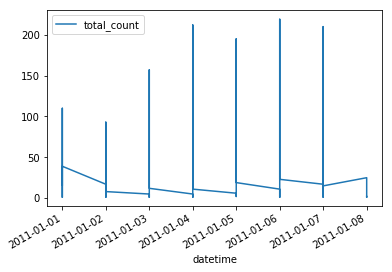

In [8]:
import matplotlib.pyplot as plt
hour_df[:24*7].plot(x='datetime', y='total_count')

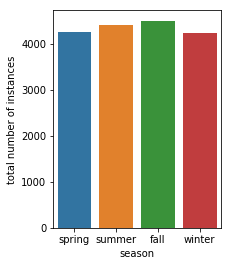

In [9]:
seasons = ['spring', 'summer', 'fall', 'winter']
# Let's check if the data is skewed / biased towards any given season

plt.figure(figsize=(3, 4))
ax = sns.countplot('season', data=hour_df)
ax.set_xticklabels(seasons)
ax.set_ylabel('total number of instances')

plt.show()

### Demand in seasons

Here I want to find demand of bikes over all seasons

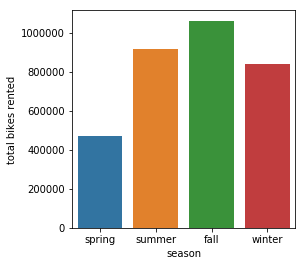

In [10]:
#demand in seasons
plt.figure(figsize=(4, 4))

ax = sns.barplot('season', 'total_count', data=hour_df, estimator=sum, ci=None)
ax.set_xticklabels(seasons)
ax.set_ylabel('total bikes rented')

plt.show()

the bargraph shows that the bikes rented based on the seasons during summer and fall the bikes are rented at very high in numbers but in the spring it is almost less than the half of the fall

In [9]:
#hour_df.head(2)

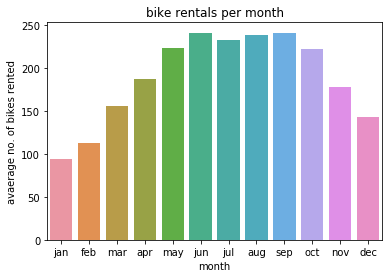

In [11]:
months = 'jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec'.split(',')
ax = sns.barplot('month', 'total_count', data=hour_df, estimator=np.mean, ci=None)
ax.set_ylabel('avaerage no. of bikes rented')
ax.set_xlabel('month')
ax.set_xticklabels(months)

plt.title('bike rentals per month')

plt.show()

the graph shows that the bike rentals average in months from may to october the average rentals is almost same where the jan and feb are the least usage 

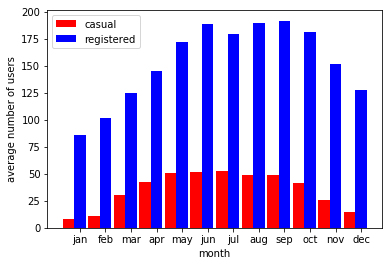

In [12]:
N = 12

y1 = hour_df.casual.groupby(hour_df.month).mean().tolist()

x = np.arange(N)
width = 0.45   # bar width

fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(x, y1, width, color='r')

y2 = hour_df.registered.groupby(hour_df.month).mean().tolist()
rects2 = ax.bar(x+width, y2, width, color='b')

ax.set_ylabel('average number of users')
ax.set_xticks(x+width)
ax.set_xticklabels(months)
ax.set_xlabel('month')
ax.legend( (rects1[0], rects2[0]), ('casual', 'registered') )

plt.show()

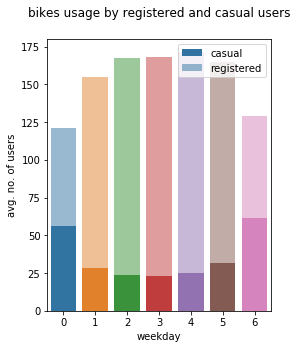

In [13]:

plt.figure(figsize=(4, 5))

ax1 = sns.barplot('weekday', 'casual', data=hour_df, estimator=np.mean, label='casual', ci=None)
ax2 = sns.barplot('weekday', 'registered', data=hour_df, estimator=np.mean, alpha=.5, label='registered', ci=None)

plt.title('bikes usage by registered and casual users', y=1.06)
plt.ylabel('avg. no. of users')
plt.legend(loc='best')

# ax2.set_xticklabels()
plt.show()

the bargraph shows that the both casual and registered people using bikes in weekday

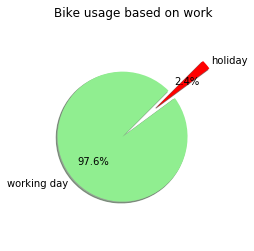

In [14]:
plt.figure(figsize=(3, 4))

labels = 'working day', 'holiday'
sizes = hour_df.total_count.groupby(hour_df.is_holiday).sum().tolist()
colors = ['lightgreen', 'red']
explode = (0.4, 0.3)

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=45)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title('Bike usage based on work')
plt.show()

the pie graph represents the bike usage based on the work the comparision between the working day and the holiday very least numbers records at holiday

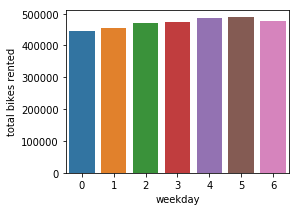

In [15]:
plt.figure(figsize=(4, 3))
ax = sns.barplot('weekday', 'total_count', data=hour_df, estimator=sum, ci=None)

ax.set_ylabel('total bikes rented')
ax.set_xlabel('weekday')

plt.show()

the graph shows that the total number of bikes rented in each day of a week. the average number of bikes rented is almost equal in every day

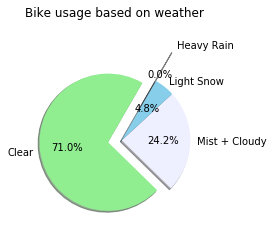

In [16]:
plt.figure(figsize=(3, 4))

labels = 'Clear', 'Mist + Cloudy', 'Light Snow', 'Heavy Rain'
sizes = hour_df.total_count.groupby(hour_df.weather_condition).sum().tolist()
colors = ['lightgreen', '#eeefff', 'skyblue', 'black']
explode = (0.2, 0, 0, 0.5)

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=60)
plt.axis('equal')
plt.title('Bike usage based on weather')
plt.show()

the graph shows that the bike usage based on weather conditions where the highest number records at clear sky

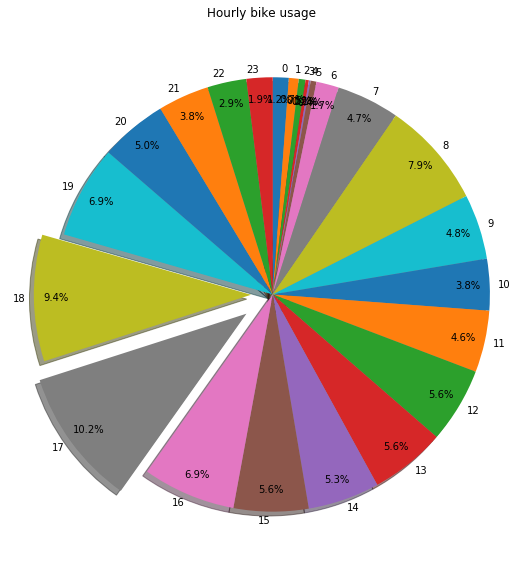

In [31]:
plt.figure(figsize=(9, 10))

labels = list(range(24))
sizes = hour_df.total_count.groupby(hour_df.hour).sum().tolist()
# colors = ['gold', '#eeefff', 'white', 'black']
explode = np.zeros(24)
explode[17] = 0.15
explode[18] = 0.1

plt.pie(sizes, labels=labels, shadow=True, startangle=90, pctdistance=.9, explode=explode,
        autopct='%1.1f%%',  counterclock=False, labeldistance=1.04)

# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title('Hourly bike usage')
plt.show()

the graph shows that the hourly bike usage where the highest usage at evening hours and the least usage at late night and early morning hours

## Data cleanup - Part2

In [18]:
hour_df = hour_df.drop(['rec_id','datetime','casual','registered'],axis=1)

In [19]:
target = hour_df.total_count
features = hour_df.drop(['total_count'],axis=1)

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaled_features = MinMaxScaler().fit_transform(features)

## Predictive analytics

In [21]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size= 0.3,random_state=42)

In [22]:
def train_and_predict_model(model, model_name, X_train, X_test, y_train, y_test, selected_cols):
    t0 = time()
    model.fit(X_train, y_train)
    train_time = time() - t0
    
    t1 = time()
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    predict_time = time() - t1
    
    train_score = r2_score(y_train, train_pred)
    
    test_score = r2_score(y_test, test_pred)
    
    root_mean_squared_log_error = rmsle(y_test, test_pred)
    
    print ("r2_score of training set of {} is {}".format(model_name, train_score))
    print ("r2_score of testing set of {} is {}".format(model_name, test_score))
    print ("Root mean squared log error of {} is {}".format(model_name, root_mean_squared_log_error))
    print ("cross_val_score of {} is {}".format(model_name, cross_val_score(model, features, target , cv = 10).mean()))
    
    print ("Time taken to train {} is {}".format(model_name, train_time))
    print ("Time taken to predict {} is {}".format(model_name, predict_time))
    return model

In [23]:
Forest = RandomForestRegressor(random_state = 0, max_depth = 20, n_estimators = 150)

In [24]:
#function to find root means squared log error
def rmsle(y, y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [27]:
from time import time
total_features = list(features.columns)
print (total_features)
#selected_features = ['hour', 'temp', 'workingday']
model = train_and_predict_model(Forest, 'Forest', X_train, X_test, y_train, y_test, total_features)

['season', 'year', 'month', 'hour', 'is_holiday', 'weekday', 'is_workingday', 'weather_condition', 'temp', 'atemp', 'humidity', 'windspeed']
r2_score of training set of Forest is 0.9917923837253887
r2_score of testing set of Forest is 0.9440718515956725
Root mean squared log error of Forest is 0.3586429153502207
cross_val_score of Forest is 0.8056152644467438
Time taken to train Forest is 11.485121965408325
Time taken to predict Forest is 1.040856122970581


In [28]:
from matplotlib import pyplot
importance = model.feature_importances_
names = list(features)

In [29]:
Importance = pd.DataFrame(sorted(zip(names,map(lambda x: round(x, 4), importance)), reverse=True),columns=['Features','Importance'])

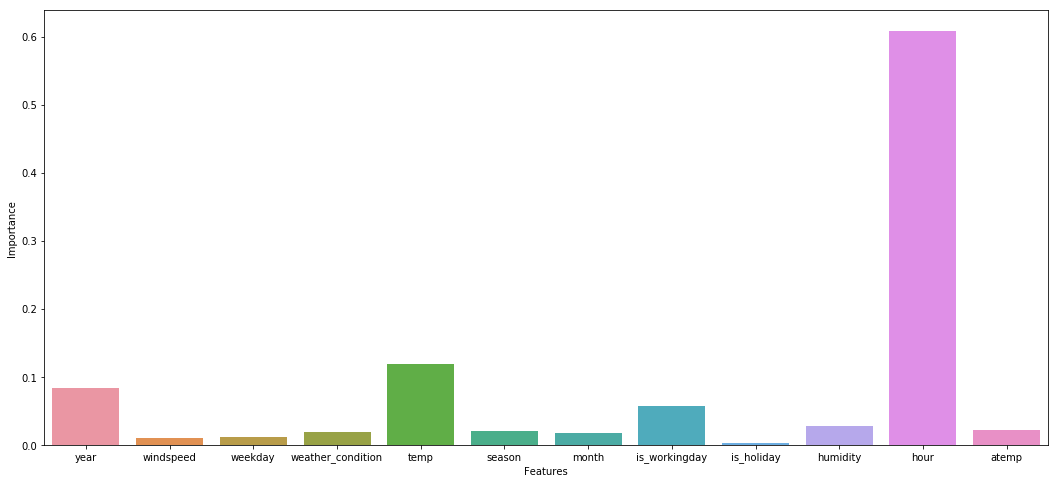

In [30]:
a4_dims = (18, 8)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.barplot(x="Features", y="Importance", data=Importance)

it concludes that the different features vs importance shows that the usage of bikes mostly hour basis that mostly the riders would choose the hour basis 